In [1]:
import pandas as pd
cols = pd.read_csv("https://raw.githubusercontent.com/pointOfive/stat130chat130/refs/heads/main/CP/var_names.csv")
data = pd.read_csv("https://raw.githubusercontent.com/pointOfive/stat130chat130/refs/heads/main/CP/CSCS_data_anon.csv",
                   na_values=["9999", "", " ", "Presented but no response", "NA"])
empty = (data.isna().sum()==data.shape[0])
data = data[empty.index[~empty]] # keep non empty columns only

dataV2 = data[data.REMOVE_case=='No'].copy()
dataV2_cohort = dataV2[dataV2.SURVEY_cohort_participant].copy()
dataV2_cohortV2 = dataV2_cohort[dataV2_cohort.SURVEY_collection_year!=2023].copy()

missingness_limit = 100 # this retains 166 of 1024 columns that aren't fully empty
columns2keep = dataV2_cohortV2.isna().sum() < missingness_limit
columns2keep = columns2keep.index[columns2keep]
dataV2_cohortV3 = dataV2_cohortV2[columns2keep].copy()
dataV2_cohortV3.shape

/tmp/ipykernel_101/844311648.py:3: DtypeWarning: Columns (129,408,630,671,689,978,1001,1002,1006,1007,1008,1080,1113,1115,1116,1117,1118,1119,1120,1121,1124,1125,1126,1127,1128,1213,1214,1215,1216,1217,1218,1263,1266,1342,1343,1344,1345,1346,1347,1348,1349,1390,1391,1393,1439,1442,1463,1546,1549,1552,1555,1558,1561) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("https://raw.githubusercontent.com/pointOfive/stat130chat130/refs/heads/main/CP/CSCS_data_anon.csv",


(850, 166)

# Analysis 1
### Research Question:
How does the frequency of visits to friends affect subjective happiness scores among individuals in the dataset?

### Variables:

* Independent Variable: CONNECTION_activities_visited_friends_p3m (categorical) – Represents the frequency of friends' visits (e.g., daily, weekly, monthly).
* Dependent Variable: WELLNESS_subjective_happiness_scale_score (continuous) – Measures individual happiness levels.

I will use a box plot to visualize the distribution of happiness scores across different categories of friends' visit frequency. This visualization is appropriate as it effectively displays the central tendency and variability of happiness scores, allowing for easy comparison between groups.

### Analysis Plan:
I will perform an exploratory analysis using box plots to assess the differences in happiness scores across the categorical variable of friends' visit frequency. Assumptions include the distribution of happiness scores being reasonably normal within groups and the independence of observations.

### Hypothesis:
I hypothesize that individuals who visit friends more frequently will report higher happiness scores compared to those who visit less often. If the analysis confirms this hypothesis, it would suggest that social interactions significantly contribute to individual well-being, supporting the idea that maintaining friendships is vital for mental health.

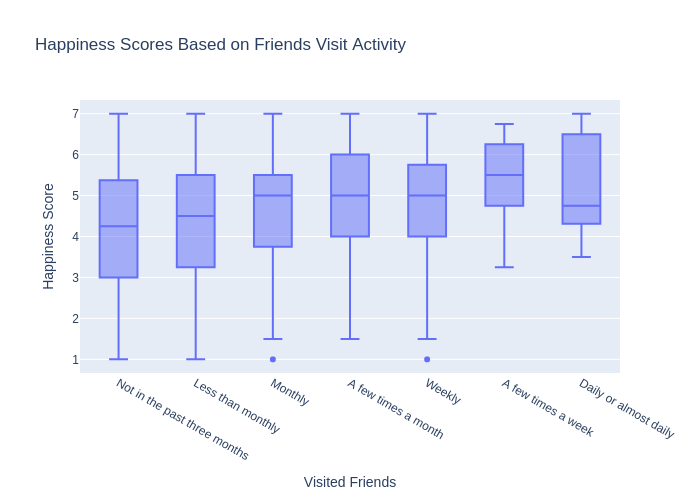

In [56]:
import plotly.express as px

# Filter out rows where the 'CONNECTION_activities_visited_friends_p3m' is null
filtered_data = dataV2_cohortV3[dataV2_cohortV3['CONNECTION_activities_visited_friends_p3m'].notnull()]

# Define the category order based on the provided counts
category_order = [
    'Not in the past three months',
    'Less than monthly',
    'Monthly',
    'A few times a month',
    'Weekly',
    'A few times a week',
    'Daily or almost daily'
]

# Create a box plot with ordered categories
fig = px.box(filtered_data, 
              x='CONNECTION_activities_visited_friends_p3m', 
              y='WELLNESS_subjective_happiness_scale_score', 
              title='Happiness Scores Based on Friends Visit Activity',
              category_orders={'CONNECTION_activities_visited_friends_p3m': category_order})

# Update axis labels
fig.update_layout(
    xaxis_title='Visited Friends',
    yaxis_title='Happiness Score'
)

# Show the figure
fig.show(renderer="png")


# Analysis 2
### Research Question:
What is the impact of family engagement on subjective happiness scores among individuals? Specifically, how do the mean happiness scores and their confidence intervals differ between those engaged with family activities and those who are not?

### Variables:

1. Family Engagement (CONNECTION_activities_visited_family_pm): Categorical variable indicating whether individuals participate in family activities (Yes/No).
2. Happiness Score (WELLNESS_subjective_happiness_scale_score): Continuous variable representing the subjective happiness score of individuals.

To visualize the data, I will create Kernel Density Estimation (KDE) plots for the bootstrapped sample means of both groups and overlay confidence interval lines to illustrate differences effectively.

### Analysis Plan:
I will perform bootstrapping to create confidence intervals for the mean happiness scores of both groups (family engaged vs. not engaged). This method is appropriate as it allows for estimation of the sampling distribution of the mean without assuming normality. The analysis will account for potential null values in the data.

The relevant assumptions include:
* The independence of observations.
* Sufficient sample size to produce stable estimates.

### Hypothesis:
I hypothesize that the mean happiness score will be higher for individuals engaged with family activities compared to those who are not. Additionally, I expect the confidence intervals for the two groups to not overlap, indicating significant difference and  suggesting a potential impact of family engagement on happiness.

In [14]:
import numpy as np
from scipy import stats

# Set a random seed for reproducibility
np.random.seed(42)

# Parameters for the bootstrapping
so_many_bootstrapped_confidence_intervals = 1000  # Number of samples
confidence_level = 95  # Confidence level for the interval

# Extracting happiness scores for family engaged and not engaged
happiness_family = dataV2_cohortV3[dataV2_cohortV3['CONNECTION_activities_visited_family_pm'] == "Yes"]['WELLNESS_subjective_happiness_scale_score']
happiness_no_family = dataV2_cohortV3[dataV2_cohortV3['CONNECTION_activities_visited_family_pm'] == "No"]['WELLNESS_subjective_happiness_scale_score']

# Function to perform bootstrapping
def bootstrap_ci(data, num_iterations=so_many_bootstrapped_confidence_intervals, n_samples=None):
    if n_samples is None:
        n_samples = len(data)  # Use the actual number of samples

    simulated_bootstrap_statistics = np.zeros(num_iterations)
    
    for i in range(num_iterations):
        bootstrap_sample = np.random.choice(data.dropna(), size=n_samples, replace=True)
        simulated_bootstrap_statistics[i] = np.mean(bootstrap_sample)

    # Calculate the confidence interval
    confidence_interval = np.percentile(simulated_bootstrap_statistics, 
                                        [(100 - confidence_level) / 2, 
                                         confidence_level + ((100 - confidence_level) / 2)])
    
    return np.mean(data), confidence_interval, simulated_bootstrap_statistics

# Bootstrapping confidence intervals for family engagement
mean_family, ci_family, family_bootstrap_samples = bootstrap_ci(happiness_family)
# Bootstrapping confidence intervals for no family engagement
mean_no_family, ci_no_family, no_family_bootstrap_samples = bootstrap_ci(happiness_no_family)

print(f"Mean Happiness Score (Family Engaged): {mean_family}")
print(f"95% Confidence Interval (Family Engaged): {ci_family}")
print(f"Mean Happiness Score (No Family Engagement): {mean_no_family}")
print(f"95% Confidence Interval (No Family Engagement): {ci_no_family}")

Mean Happiness Score (Family Engaged): 4.7717065868263475
95% Confidence Interval (Family Engaged): [4.61739914 4.90996037]
Mean Happiness Score (No Family Engagement): 4.29881974248927
95% Confidence Interval (No Family Engagement): [4.16750519 4.42483143]


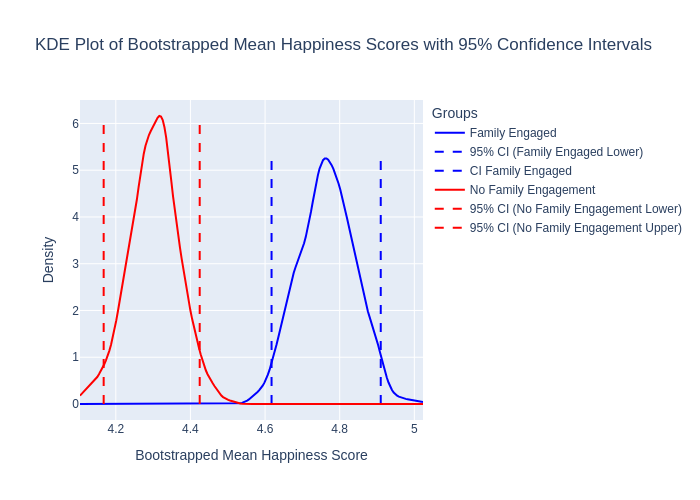

In [57]:
import plotly.graph_objects as go
import numpy as np
from scipy import stats

# KDEs
kde_family = stats.gaussian_kde(family_bootstrap_samples)
kde_no_family = stats.gaussian_kde(no_family_bootstrap_samples)

x_values = np.linspace(min(min(family_bootstrap_samples), min(no_family_bootstrap_samples)),
                       max(max(family_bootstrap_samples), max(no_family_bootstrap_samples)), 200)

# Create the plot
fig = go.Figure()

# Family Engaged KDE
fig.add_trace(go.Scatter(x=x_values, y=kde_family(x_values), mode='lines', 
                         name='Family Engaged', line=dict(color='blue')))

# Vertical dashed lines for Family Engaged CI
fig.add_trace(go.Scatter(x=[ci_family[0], ci_family[0]], y=[0, max(kde_family(x_values))],
                         mode='lines', line=dict(color='blue', dash='dash'),
                         name="95% CI (Family Engaged Lower)"))

fig.add_trace(go.Scatter(x=[ci_family[1], ci_family[1]], y=[0, max(kde_family(x_values))],
                         mode='lines', line=dict(color='blue', dash='dash'), name='CI Family Engaged'))

# No Family Engagement KDE
fig.add_trace(go.Scatter(x=x_values, y=kde_no_family(x_values), mode='lines', 
                         name='No Family Engagement', line=dict(color='red')))

# Vertical dashed lines for No Family Engagement CI
fig.add_trace(go.Scatter(x=[ci_no_family[0], ci_no_family[0]], y=[0, max(kde_no_family(x_values))],
                         mode='lines', line=dict(color='red', dash='dash'),
                         name="95% CI (No Family Engagement Lower)"))

fig.add_trace(go.Scatter(x=[ci_no_family[1], ci_no_family[1]], y=[0, max(kde_no_family(x_values))],
                         mode='lines', line=dict(color='red', dash='dash'), name="95% CI (No Family Engagement Upper)"))

# Layout adjustments
fig.update_layout(
    title="KDE Plot of Bootstrapped Mean Happiness Scores with 95% Confidence Intervals",
    xaxis_title="Bootstrapped Mean Happiness Score",
    yaxis_title="Density",
    legend_title="Groups"
)

fig.show(renderer="png")


In [52]:
import statsmodels.api as sm

# Drop rows with missing values in the relevant columns
cleaned_data = dataV2_cohortV3[['WELLNESS_life_satisfaction', 'LONELY_ucla_loneliness_scale_score']].dropna()

# Prepare the data
X = cleaned_data['LONELY_ucla_loneliness_scale_score']  # Independent variable
y = cleaned_data['WELLNESS_life_satisfaction']  # Dependent variable

# Add a constant to the independent variable for the intercept
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()


# Analysis 3
### Research Question:
What is the relationship between loneliness (measured by the UCLA Loneliness Scale) and life satisfaction (measured by a life satisfaction score)?

### Variables:

* Independent Variable: Loneliness Score (LONELY_ucla_loneliness_scale_score)
* Dependent Variable: Life Satisfaction (WELLNESS_life_satisfaction)
These variables are chosen to explore how loneliness might affect an individual's overall life satisfaction. A scatter plot with a regression line will visually represent this relationship.

To visualize the data, I will create Kernel Density Estimation (KDE) plots for the bootstrapped sample means of both groups and overlay confidence interval lines to illustrate differences effectively.

### Analysis Plan:
I will perform a linear regression analysis using OLS (Ordinary Least Squares) to quantify the association. Key assumptions include linearity, independence, homoscedasticity, and normality of residuals.

### Hypothesis:
I hypothesize that higher loneliness scores will correlate with lower life satisfaction. This analysis will help understand the psychological implications of loneliness on well-being, providing insights for interventions aimed at improving life satisfaction.

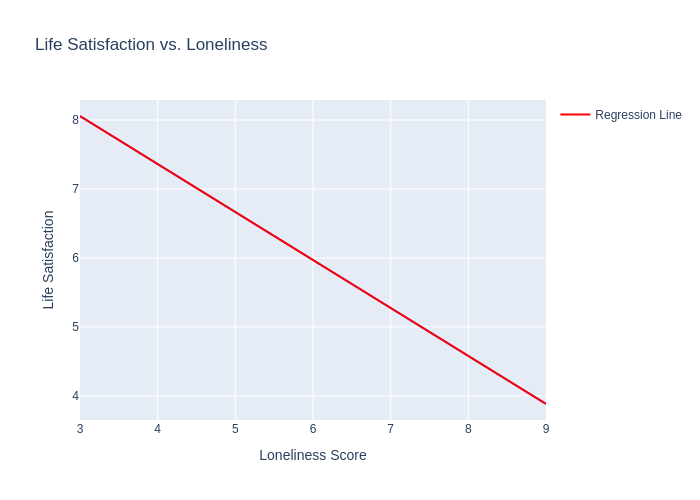

In [58]:
import numpy as np
import plotly.express as px
import statsmodels.api as sm

# Assuming cleaned_data is already defined and does not contain NaN values
# Fit the regression model
X = cleaned_data['LONELY_ucla_loneliness_scale_score']
y = cleaned_data['WELLNESS_life_satisfaction']
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()

# Create the plot without scatter points
fig = px.line(x=cleaned_data['LONELY_ucla_loneliness_scale_score'],
               y=model.predict(X),
               title='Life Satisfaction vs. Loneliness',
               labels={'x': 'Loneliness Score', 
                       'y': 'Life Satisfaction'})

# Add the regression line to the plot
fig.add_scatter(x=cleaned_data['LONELY_ucla_loneliness_scale_score'], 
                 y=model.predict(X), 
                 mode='lines', 
                 name='Regression Line', 
                 line=dict(color='red'))

# Show the figure
fig.show(renderer="png")
